In [392]:
# first import data 
#sshfs ascott47@jhu.edu@gateway2.marcc.jhu.edu:/scratch/groups/bzaitch1/badr/ mountpoint/
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import matplotlib.cm as cm
import scipy.spatial
import os 

#from netCDF4 import Dataset
#from wrf import getvar
#import wrf
#from wrf import ALL_TIMES
#### 

import scipy.stats
# define plots
def easy_scatter(x,y,title='', xlabel='', ylabel='') : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    plt.scatter(x,y, color = 'grey')
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(ind[ind].shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, r, p

from scipy.odr import Model, Data, ODR
from scipy.stats import linregress
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

def easy_scatter_tls(x,y,title='', xlabel='', ylabel='', text_y_loc = .9 , text_x_loc = .5) : 
        linear = Model(f)
        ind = ~np.isnan(y) & ~np.isnan(x)
        linreg = scipy.stats.linregress(x[ind], y[ind])
        mydata = Data(x[ind], y[ind])
        myodr = ODR(mydata, linear, beta0=linreg[0:2]) # beta0 are initial guesses for paremeter values, ie, intercept and slope
        myoutput = myodr.run()
        # t-test for tls regression coeff
        DF = y[ind].shape[0] -2 # for a linear model
        b1 = myoutput.beta[0] # slope
        H0 = 1 # null hypothesis
        SE = myoutput.sd_beta[0]
        t = (b1-H0)/SE
        p = scipy.stats.t.cdf(t,df=DF)
        # plot it  
        plt.plot(x, f(myoutput.beta, x), 'k')
        plt.plot(np.linspace(x.min(), x.max(), 20),np.linspace(x.min(), x.max(), 20), '--k' )
        plt.scatter(x,y,color = 'grey', alpha =.5)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(['y = %.2f x + %.2f'%(myoutput.beta[0], myoutput.beta[1]),
                    '1-1 line', 'Data'], loc=2, frameon =False)
        plt.title(title)
        return myoutput.beta[0], myoutput.beta[1],linreg.rvalue, p

plt.style.use('ggplot')
# read in temp data 
filepath = '../cityheat/Bmore/2016/'

meta = pd.DataFrame(pd.read_csv(filepath + 'data/CleanedMeta2016.csv', sep = ','))
meta = meta.set_index('sensornumber', drop = False)
meta = meta.set_index(meta.index.astype('float64'), drop = False)
#mean_temp = pd.read_csv('meantemp.csv', header=-1).rename(columns = {0: 'SensorNumber', 1:'MeanTemp'}).set_index('SensorNumber')
tempDF = pd.read_csv(filepath + 'data/CleanedTemp2016.csv', parse_dates = [0]).set_index('Date').resample('H', how = 'first')#.first()
tempDF.columns = tempDF.columns.astype('int')
# remove data before the thermometer was installed
for ind in tempDF.columns : 
    start_hour = pd.to_datetime(meta.loc[ind,'time'][0:13] + ':00:00 UTC ' + meta.loc[ind,'time'][-4:])
    tempDF.loc[:start_hour,ind] = np.nan
    
rhDF = pd.read_csv(filepath + 'data/CleanedRH2016.csv', parse_dates = [0]).set_index('Date').resample('H', how = 'first')
rhDF.columns = rhDF.columns.astype('int')
for ind in rhDF.columns : 
    start_hour = pd.to_datetime(meta.loc[ind,'time'][0:13] + ':00:00 UTC ' + meta.loc[ind,'time'][-4:])
    rhDF.loc[:start_hour,ind] = np.nan
    
urban_sensor = 86 #97 # science center
rural_sensor = 4 #68 # darryn's house

# import data to classify dry days and wet days 
file =  'data/' + 'BWI'+ '.dbdmt'
synopticDF =  pd.read_table(file, sep = ' ', header =  None, parse_dates = [1])
synopticDF.columns = ['id','date', 'ssc']
synopticDF = synopticDF.set_index(synopticDF['date'])
synopticDF['ssc'].loc[synopticDF['ssc']> 60] =6.5
syn = synopticDF['ssc']['2016-06-01': '2016-09-15'].resample('D').mean()#[pd.PeriodIndex(UHI.index, freq = 'D')[0]:pd.PeriodIndex(UHI.index, freq = 'D')[-1]]

# import asos obs
date_parser = pd.core.tools.datetimes.to_datetime # pd.datetools.to_datetime
asos = pd.read_csv('data/mdASOS_summer_2016.csv', parse_dates = ['valid'], date_parser = date_parser).set_index('valid')
asos.columns = ['station', 't_f', 't_c', 'dew_f', 'dew_c']
# correct for local time
asos.index = asos.index- pd.Timedelta('04:00:00')

for column in ['t_f', 't_c', 'dew_f', 'dew_c']: 
    asos[column] = pd.to_numeric(asos[column],errors='coerce')
obs = pd.DataFrame(index = asos.resample('H').mean().index, columns = ['rural', 'urban'])
obs['urban'] =  asos[asos['station'] =='DMH']['t_c'].resample('H').mean()
obs['rural'] =  asos[asos['station'] =='BWI']['t_c'].resample('H').mean()

/Users/ascott47/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:82: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
/Users/ascott47/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:89: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
/Users/ascott47/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


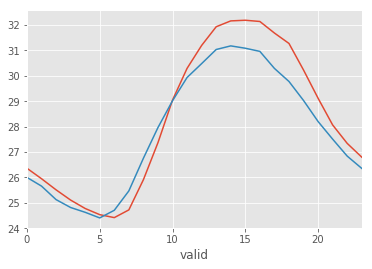

In [389]:
tempDF['2016-07-01':'2016-08-31'][97].groupby(tempDF['2016-07-01':'2016-08-31'].index.hour).mean().plot()
obs['2016-07-01':'2016-08-31']['urban'].groupby(obs['2016-07-01':'2016-08-31'].index.hour).mean().plot(label = 'ASOS')

# Subtract off science center bias

In [481]:
tempDF_uncorrected = tempDF.copy()
start_date = '2016-07-01'
end_date = '2016-08-30'
bias = tempDF[97].subtract(obs['urban'])['2016-07-01':'2016-08-31']
avg_daily_bias = bias.groupby(bias.index.hour).mean()
smoothed_bias = pd.concat([avg_daily_bias, avg_daily_bias, avg_daily_bias]).rolling(3, center = True).mean().iloc[24:48]
tempDF_corrected = tempDF_uncorrected.subtract(smoothed_bias[tempDF_uncorrected.index.hour].values,axis=0)
tempDF= tempDF_corrected[start_date:end_date]#.drop(41,axis=1)
meta = meta.loc[tempDF.columns]

In [454]:
tempDF.to_csv('data/correctedibuttontemp2016.csv')

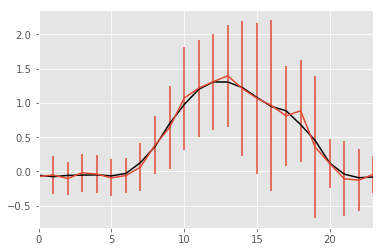

In [422]:
bias.groupby(bias.index.hour).mean().plot(yerr = bias.groupby(bias.index.hour).std())
smoothed_bias.plot(style='k')

In [450]:
tempDF_corrected = tempDF_uncorrected.subtract(smoothed_bias[tempDF_uncorrected.index.hour].values,axis=0)
tempDF= tempDF_corrected[start_date:end_date]

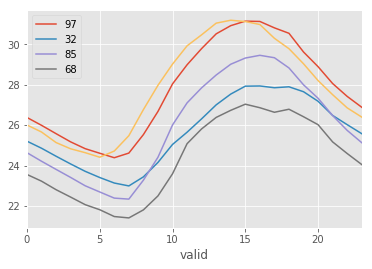

In [451]:
tempDF[selected].groupby(tempDF.index.hour).mean().plot()
obs[start_date:end_date]['urban'].groupby(obs[start_date:end_date].index.hour).mean().plot(label = 'ASOS')

(0.11630205601821574, 0.55052563088353068, 1.5400366638563518e-112)

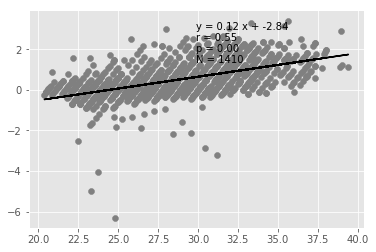

In [406]:
easy_scatter(tempDF[97][bias.index], bias)

(0.15806478608987731, 0.45339007168870243, 0.00031073465511819446)

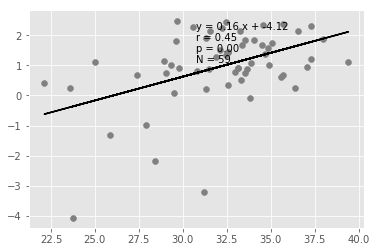

In [410]:
easy_scatter(tempDF[tempDF.index.hour==16][start_date:end_date][97], 
            bias[bias.index.hour==16][start_date:end_date])

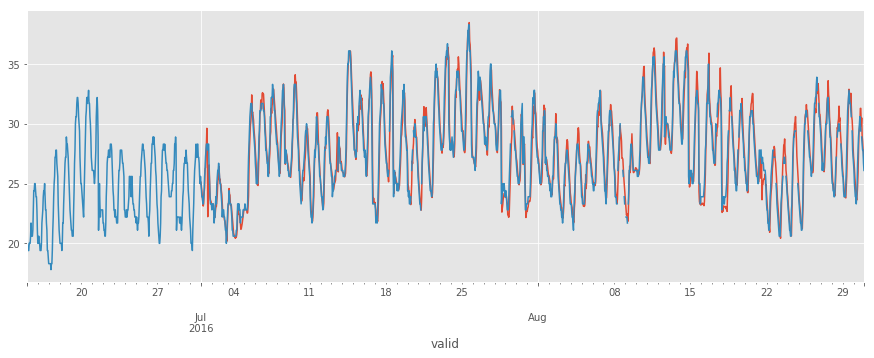

In [455]:
tempDF[97][ '2016-06-15':'2016-08-30'].plot(figsize = [15,5])
obs['urban'][ '2016-06-15':'2016-08-30'].plot()

# Map (could also be spatial variability?) 

In [319]:
import cartopy.crs as ccrs
import matplotlib

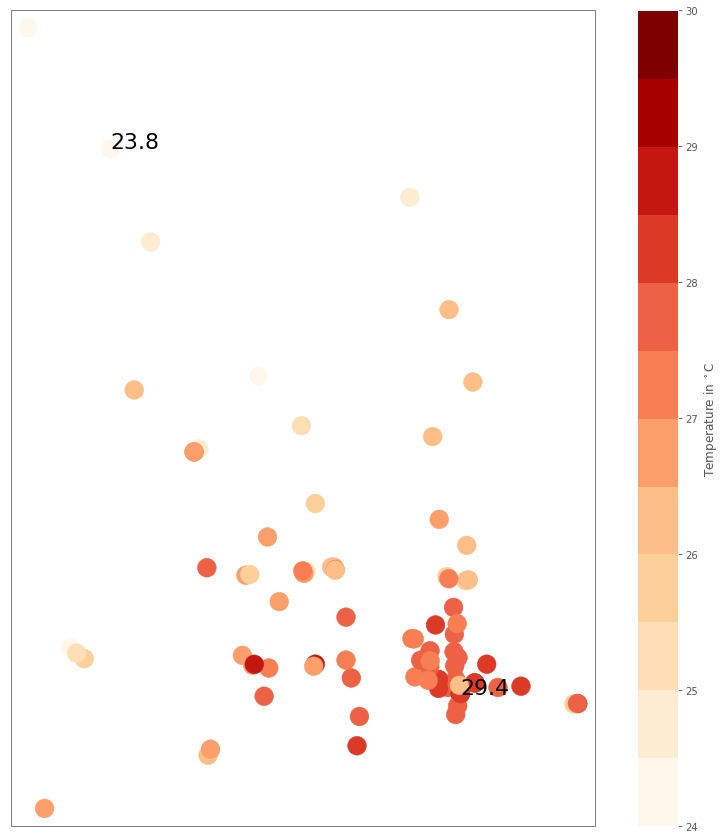

In [442]:
x = meta['location:Longitude'].values
y = meta['location:Latitude'].values
c = tempDF.mean(axis=0)
marker_size = 350
fig = plt.figure(figsize=[15,15])
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent(( meta['location:Longitude'].min()-.005,
               meta['location:Longitude'].max()+.005 ,
               meta['location:Latitude'].min()-.005,
               meta['location:Latitude'].max()+.005))

cmap = matplotlib.cm.OrRd
bounds = np.linspace(round((c.mean()-3)),round((c.mean()+3)),13)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
plotHandle = ax.scatter(x,y,c = c, s = marker_size, transform=ccrs.Geodetic(),
             cmap = cmap,
             norm = norm)

cbar1 = plt.colorbar(plotHandle, label = 'Temperature in $^\circ $C')
lon = x[np.nanargmax(c)]
lat = y[np.nanargmax(c)]
at_x, at_y = ax.projection.transform_point(lon, lat,
                                           src_crs=ccrs.Geodetic())
plt.annotate(
    '%2.1f'%np.nanmax(c.values), xy=(at_x, at_y), #xytext=(30, 20), textcoords='offset points',
    color='black', backgroundcolor='none', size=22,
    )

lon = x[np.nanargmin(c)]
lat = y[np.nanargmin(c)]
at_x, at_y = ax.projection.transform_point(lon, lat,
                                           src_crs=ccrs.Geodetic())
plt.annotate(
    '%2.1f'%np.nanmin(c.values), xy=(at_x, at_y), #xytext=(30, 20), textcoords='offset points',
    color='black', size = 22, backgroundcolor='none')

In [31]:
# would be helpful to have this as a plotly object

In [329]:
sci_center = 97
urbn_park = 32
north_city = 85
rural = 68
selected = [97,32,85,68]

# Diurnal cycle 

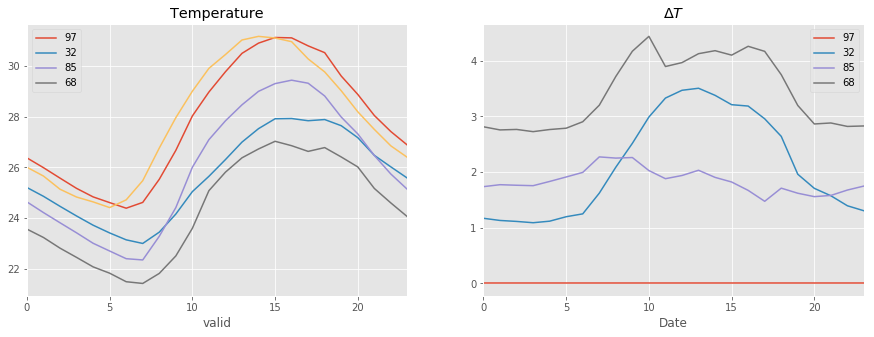

In [445]:
plt.figure(figsize = [15,5])
#plot temp
ax = plt.subplot(1,2,1)
tempDF[selected].groupby(tempDF.index.hour).mean().plot(ax=ax)
obs[start_date:end_date]['urban'].groupby(obs[start_date:end_date].index.hour).mean().plot(ax=ax, label = 'ASOS')
ax.set_title('Temperature')
# plot DT
ax = plt.subplot(1,2,2)
(tempDF*-1).add(tempDF[97], axis=0).groupby(tempDF.index.hour).mean()[selected].plot(ax=ax)
ax.set_title('$\Delta T$')

# UHI intensity as a function of distance from the city center
# Variability within city

http://connor-johnson.com/2014/03/20/simple-kriging-in-python/


The semi-variance provides a measure of spatial variance as a function of distance; it indicates an average difference between two data points $f(a), f(a+h)$ given their distance apart $h$: 
$$ s(h) = \frac{1}{2 N(h)} \sum _{N(h)} \left(f(a+h) -f(a)\right)^2 $$
Here, we calculate the experimental semi-variance by making $h$ a discrete variable equal to fixed-width distances. 

/Users/ascott47/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in double_scalars


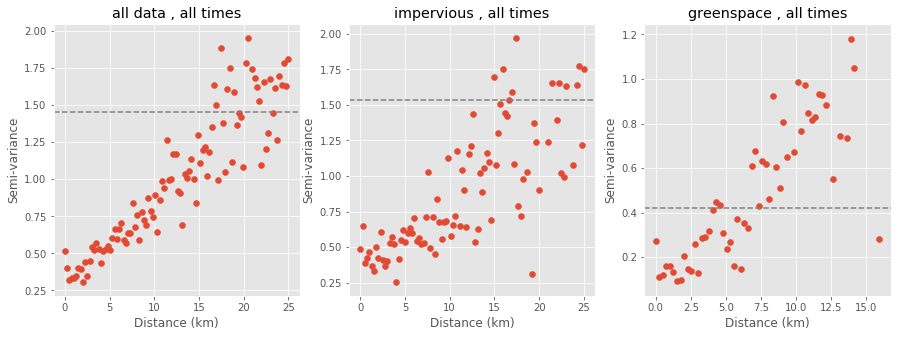

In [482]:
r_earth = 6371
locations0 = np.array([meta['location:Longitude'].dropna(), meta['location:Latitude'].dropna()]).T
data0 = tempDF.mean()[meta['location:Longitude'].dropna().index].values

locations1 = np.array([meta['location:Longitude'][meta['landcoverclass']=='grass'].dropna(), 
                      meta['location:Latitude'][meta['landcoverclass']=='grass'].dropna()]).T
data1 = tempDF.mean()[meta['location:Longitude'][meta['landcoverclass']=='grass'].dropna().index].values

locations2 = np.array([meta['location:Longitude'][meta['landcoverclass']=='impervious'].dropna(), 
                      meta['location:Latitude'][meta['landcoverclass']=='impervious'].dropna()]).T
data2 = tempDF.mean()[meta['location:Longitude'][meta['landcoverclass']=='impervious'].dropna().index].values

squared_difference = np.zeros([N,N])
distances = np.zeros([N,N])
#hs = np.linspace(0,.25, 50)/360*2*np.pi*r_earth
hs = np.linspace(0,25,100)
bandwidth = np.abs(hs[1]-hs[0])
fig =plt.figure(figsize=[15,5])
iii = 1
for data,locations,label in zip([data0,data1,data2], [locations0,locations1,locations2], ['all data', 'impervious', 'greenspace']):
    N = data.shape[0]
    ax = plt.subplot(1,3,iii)
    semivariogram = pd.DataFrame(index = hs, columns= ['semivariogram'])
    for h in hs:
        Z = []
        for i in range(N): 
            for j in range(i+1,N): 
                #distances[i,j] = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                distance = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                if (distance >= h) and (distance< h+bandwidth):
    #            if (distance[i,j] >= h-bandwidth) and (distance[i,j]< h+bandwidth)
                    Z.append(np.abs(data[i] - data[j])) 
        semivariogram.loc[h, 'semivariogram']= np.sum(Z)/(2.0*len(Z))
    ax.scatter(semivariogram.index, semivariogram.semivariogram)
    ax.axhline(data.var(), linestyle ='--', color = 'gray')
    ax.set_title('%s , all times'%label)
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Semi-variance')
    iii = iii+1

/Users/ascott47/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


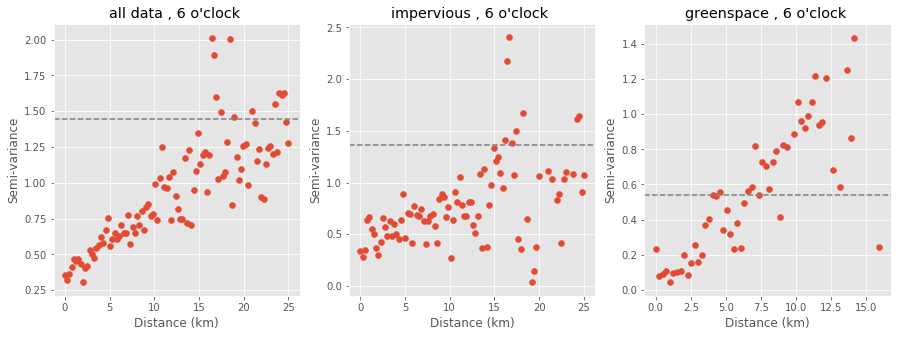

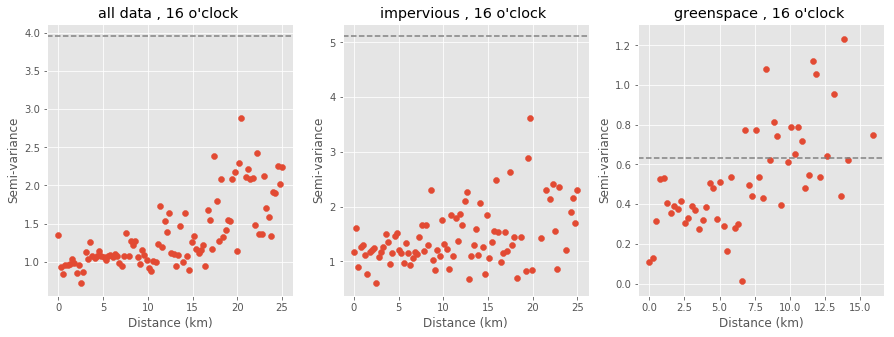

In [483]:
r_earth = 6371
for hr in [6,16]: 
    locations0 = np.array([meta['location:Longitude'].dropna(), meta['location:Latitude'].dropna()]).T
    data0 = tempDF[tempDF.index.hour ==hr].mean()[meta['location:Longitude'].dropna().index].values

    locations1 = np.array([meta['location:Longitude'][meta['landcoverclass']=='grass'].dropna(), 
                          meta['location:Latitude'][meta['landcoverclass']=='grass'].dropna()]).T
    data1 = tempDF[tempDF.index.hour ==hr].mean()[meta['location:Longitude'][meta['landcoverclass']=='grass'].dropna().index].values

    locations2 = np.array([meta['location:Longitude'][meta['landcoverclass']=='impervious'].dropna(), 
                          meta['location:Latitude'][meta['landcoverclass']=='impervious'].dropna()]).T
    data2 = tempDF[tempDF.index.hour ==hr].mean()[meta['location:Longitude'][meta['landcoverclass']=='impervious'].dropna().index].values

    squared_difference = np.zeros([N,N])
    distances = np.zeros([N,N])
    #hs = np.linspace(0,.25, 50)/360*2*np.pi*r_earth
    hs = np.linspace(0,25,100)
    bandwidth = np.abs(hs[1]-hs[0])
    fig =plt.figure(figsize=[15,5])
    iii = 1
    for data,locations,label in zip([data0,data1,data2], [locations0,locations1,locations2], ['all data', 'impervious', 'greenspace']):
        N = data.shape[0]
        ax = plt.subplot(1,3,iii)
        semivariogram = pd.DataFrame(index = hs, columns= ['semivariogram'])
        for h in hs:
            Z = []
            for i in range(N): 
                for j in range(i+1,N): 
                    #distances[i,j] = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                    distance = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                    if (distance >= h) and (distance< h+bandwidth):
        #            if (distance[i,j] >= h-bandwidth) and (distance[i,j]< h+bandwidth)
                        Z.append(np.abs(data[i] - data[j])) 
            semivariogram.loc[h, 'semivariogram']= np.sum(Z)/(2.0*len(Z))
        ax.scatter(semivariogram.index, semivariogram.semivariogram)
        ax.axhline(data.var(), linestyle ='--', color = 'gray')
        ax.set_title('%s , %i o\'clock '%(label,hr))
        ax.set_xlabel('Distance (km)')
        ax.set_ylabel('Semi-variance')
        iii = iii+1

In [496]:
data[0].var()

0.0

In [497]:
data0.var()

3.9573588574934084

In [499]:
data0.std()

1.989311151502803

In [ ]:
# to do: label variance lines, possibly label data w/in 1km?, standardize axis limits

We next examine how different locations vary from one aonther. Figure Xa shows a semi-variogram: the semi-variance (in units of variance or $^\circ C^2$ )is plotted against distance for all locations at 6am. For sites within one kilometer of one another, the semi-variance is less than $0.5$, which translates to temperature differences of $0.7^\circ$C on average. As distance between sites increases, the semi-variance increases linearly, indicating that farther away points are more and more dissimilar.  While the semi-variance is noisier at longer distances, this is due to having fewer datapoints at certain distances. This may be why the semi-variogram is exceeds its theoretical limit of the sample variance for some of the distances between 15-25 kilometers. Overall, we see that sites closer together are more similar and farther sites are more dissimilar.  

It is possible that variability in the land type drives temperature variability. In Figure Xb, we look at sites dominated by impervious landcover at 6am and see that the variogram follows a similar pattern to that of Fig.~Xa: closer sites are similar and farther sites are dissimilar. At distances beyond 15km, the semi-variances remain close to the variance of X.  This is in contrast with the semi-variogram for green landcovers at 6am (Fig.Xc). Though  overall green sites have lower variance, the semi-variance increases with distance without evidence of a limit.

In the afternoon, variability is higher for variograms of all sites, impervious sites, and green sites at 6pm (Fig.Xd,e,f). The variance for all data, $3.9^\circ C$ (Fig.Xd), translates into an average temperature difference of 1.98$^\circ $ degrees, much higher than that at 6am. Impervious spaces remain dissimilar for the range of distances examined (Fig.~Xe). Greenspaces grow dissimilar at a constant rate, but remain less variable than impervious spaces.

This suggests that: 
- average temperature difference across sites is several degrees at most
- spatial variability lower at 6 am than at 4pm (PUT NUMBERS HERE)
- green spaces more variable than non-green spaces 
This implies that temperature variability within the urban heat island is lower than suggested by satellite land surface temperature products. 
Futhermore, as semi-variograms fit to are used in Kreiging spatial estimation technique this suggests that the simple Kreiging model would accurately model temperature data in an urban setting. 

# Variability by landcover type

We need to know: how does temp vary with landcover type

# Change during warmer periods

easy_scatter_tls()